- Ctrl+Enter to run a cell
- Shift+Enter to run a cell and go to the next cell
- **Download this Notebook file [here](http://pmx.mpibpc.mpg.de/Tutorial2025/aminoacid_tut/aminoacid_tutorial.ipynb)**

----------
- Authors  : Sudarshan Behera, Lisa Schmidt, and Bert de Groot
- Goal  : Learn step-by-step how to perform free energy calculations for amino acid mutations using pmx and gromacs. 
- Duration  : ~90 mins
__________

----------
# Introduction
__________

In this tutorial we will use pmx and Gromacs to set up alchemical free energy calculations for the change in thermostability of Trp-cage upon amino acid mutation. We will mutate the 6th residue from Tryptophan (W) to Phenylalanine (F).

We will follow the protocol similar to the this paper:<br>
*Gapsys, V et al. Accurate and Rigorous Prediction of the Changes in Protein Free Energies in a Large-Scale Mutation Scan.  2016. Angewandte Chemie<br>
https://onlinelibrary.wiley.com/doi/full/10.1002/anie.201510054* <br>

In order to calculate how a mutation affects the folding free energy of a protein ($\Delta \Delta G^{Mutation}_{Folding}$), we need to calculate the free energy difference of alchemically mutating both the folded and unfolded state of the protein ($\Delta G^{Mutation}_{Folded}$−$\Delta G^{Mutation}_{Unfolded}$). Effectively, we use the following thermodynamic cycle to recover ΔΔG via the non-physical transformations shown as the horizontal legs of the cycle. The experimentally measured $\Delta \Delta G^{Mutation}_{Folding}$ is **12.5 $\pm$ 0.6 kJ/mol**.<br>

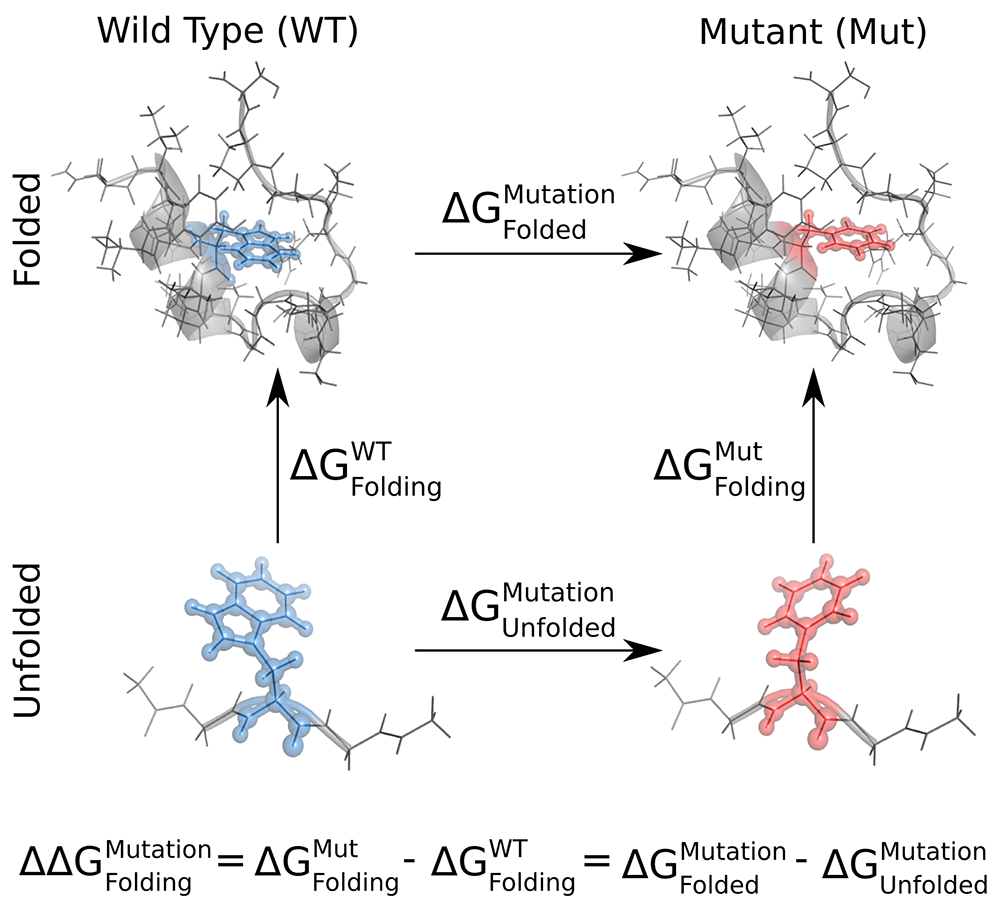

# Prerequisite

- Knowledge of basic linux commands and python.
- An already installed GROMACS and a basic understanding of GROMACS simulation set up is required. You can follow [this tutorial](https://tutorials.gromacs.org/docs/md-intro-tutorial.html) for the same.
- **PMX installation. The steps are as follows:** <br>
-------------------
        conda create -n PMX python=3.7
        conda activate PMX
        conda install numpy matplotlib scipy pip jupyterlab pandas rdkit
        git clone https://github.com/deGrootLab/pmx
        cd pmx
        git checkout develop
        pip install .
-------------------
- **Input Files:** The [tutorial_files.zip](http://pmx.mpibpc.mpg.de/Tutorial2025/aminoacid_tut/tutorial_files.zip) contains all the files required to run this tutorial. **inputs**: pdb and mdp files; **workpath_precalculated**: some pre-simulated files; **AAtutorial.py**: a script file containing various functions for smooth implementation of the tutorial.

------------------
# Method
------------------
We will set up the calculations in a non-equilibrium framework.<br>
Firstly, two 20 ns long equilibrium simulations will be performed in the physical states A and B. This will be done only for the folded protein in this tutorial. <br>
Here, we will go through the steps for the calculation of $\Delta G^{Mutation}_{Folded}$, using the inputs/protein.pdb file provided. $\Delta G^{Mutation}_{Unfolded}$ can be obtained by following exactly the same steps, but using the file inputs/tripeptide.pdb as the starting structure.  
Afterwards, we will extract snapshots from the equilibrium simulations and run 100 rapid (50 ps each) transitions in the directions A->B and A<-B.<br>
During the transitions, we will record the work required for the amino acid morphing. Finally, the work will be related to $\Delta G$ by applying Crooks fluctuation theorem.


---------------
Workflow
-----------------
The overall workflow consists of the following steps:<br>

0. Initialize the working environment
1. Prepare hybrid structures/topologies
2. Prepare equilibrium simulations
3. Prepare non-equilibrium transitions
4. Analysis


The workflow in sketched in the following figure. The protocol is shown and followed for estimation of $\Delta G^{Mutation}_{Folded}$ in this tutorial and the same can be followed to estimate $\Delta G^{Mutation}_{Unfolded}$.

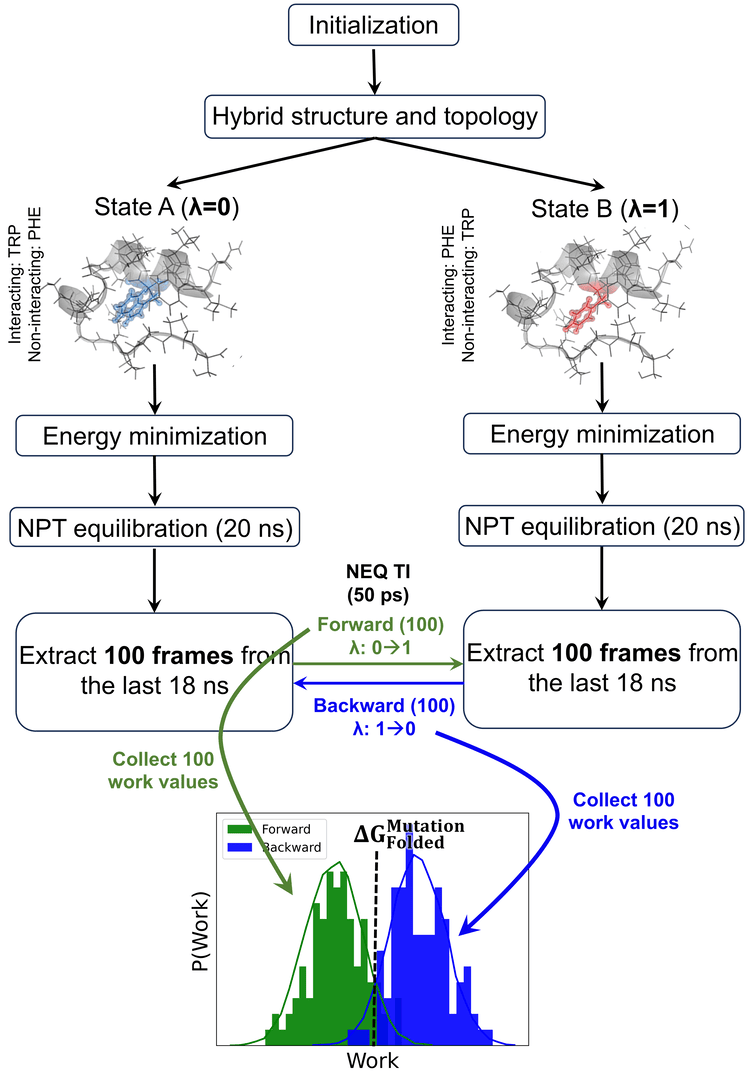

Download and unzip the input files.

In [ ]:
import subprocess
subprocess.call('wget http://pmx.mpibpc.mpg.de/Tutorial2025/aminoacid_tut/tutorial_files.zip', shell=True) #Download input_files.zip
subprocess.call('unzip tutorial_files.zip', shell=True)

import essential modules

In [ ]:
import pmx
from pmx.utils import create_folder
from pmx import gmx, jobscript
import sys
import numpy as np
from IPython.core.display import clear_output
import os,shutil
import re
import subprocess
import glob
import random
from AAtutorial import *

----------------
Step 0. Initialize working environment
-----------------

Here, we will define the paths to the protein.pdb, as well as to the molecular dynamics parameter files (.mdp).

We will also set some main parameters: water model, salt concentration, forcefield, and number of simulation replicas to use.

In [ ]:
# initialize the free energy environment object: it will store the main parameters for the calculations
fe = AAtutorial( )

# set the workpath
fe.workPath = 'workpath'
# set the path to the pdb file
fe.pdbfile = 'inputs/protein.pdb'
# set the path to the molecular dynamics parameter files
fe.mdpPath = 'inputs/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe.replicas = 1
# choose the forcefield of your choice
fe.ff = 'amber99sb-star-ildn-mut'
# provide amino acids as single-letter code and the resid
fe.edges = [ ['W', 'F'] ]
fe.resids = [6]

# finally, let's prepare the overall free energy calculation directory structure
fe.prepareFreeEnergyDir( )

------------------
Step 1. Prepare hybrid structure and topology.
---------------------

`We will construct a hybrid structure and topology based on the pmx library.`

In [ ]:
fe.hybrid_structure_topology(bVerbose=False)

------------------
Step 2. Prepare equilibrium simulations.
---------------------
Prepare simulation boxes with solvent and ions.
Subsequently energy minimize the systems, prepare equilibrium simulations and start the runs.

`2a. Build boxes, solvate, add ions`. This is performed with the help of gromacs inbuilt modules.

In [ ]:
fe.boxWaterIons( )

`2b. Energy minimization.`<br>
Prepare the simulation and subsequently either<br>
 a) run locally (suitable for the tutorial purpose)<br>
 b) create jobscripts to submit to the cluster

In [ ]:
fe.prepare_simulation( simType='em' )

Running energy minimization locally (e.g. on a laptop) will take ~2 minutes for one replica.<br>
You can use the command below for that.
If you do not want to wait that long and have an access to a cluster, skip this step and proceed to the next step.

In [ ]:
fe.run_simulation_locally( simType='em')

We can also submit the jobs to run on the cluster.<br>
This, naturally, requires some knowledge of the cluster available, queueing system and some dependencies. Several jobscript parameters allow to define the environment on the cluster. If there are additional cluster specifics, the jobscripts can be easily modified.<br>

Together with the jobscripts, a script `workpath/submit.py` will be generated. This script can be used to simply submit all the jobs to the cluster.

In [ ]:
# set several parameters
fe.JOBsimcpu = 16
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2024']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'gmx_threads_AVX_256 mdrun -pin on'
fe.JOBpartition= 'p20,p24,p00,p32,p08,p16' #'short'

# create the jobscripts
fe.prepare_jobscripts(simType='em')

`2c. Once the energy minimization has finished, we can prepare equilibrium simulations.`

Again, prepare and submit the equilibrium simulation jobs to the cluster.<br>
This time the calculation will take longer, depending on the available computational resource (we are performing 20 ns simulations).<br>

In [ ]:
fe.prepare_simulation( simType='eq')

In [ ]:
fe.prepare_jobscripts(simType='eq')

### The calculations for this step (and for the following step 3) would take a while. Therefore, We have already performed the simulations in advance, so we do not need to wait. ###
`To use the pre-calculated data, simply change the working directory of your tutorial object "fe" (command below). By default, all your calculations were performed in the "workpath" directory. The following command will set it to the "workpath_precalculated". We will also set the number of replicass to 1, because for the brevity of the current tutorial only one repetition of the calculation was performed.`<br>
Note, that in the folder "workpath_precalculated" only the final results, i.e. dhdl.xvg files, have been generated for all the replicas for the forwards/reverse directions for the solvated ligand and ligand-protein complex. The raw generated trajectories are only provided for two cases: 'protein/stateA/run1' and 'protein/stateB/run1'. This is simply due to the large size of the trajectories: all the simulation data would take more than 2 GB. This means that `Step 3` can only be performed for one replica. However, this is not a concern for the final analysis in `Step 4`, because the results from the transitions are present for all the cases considered in the tutorial.

In [ ]:
fe.workPath = 'workpath_precalculated'

--------------
Step 3. Prepare non-equilibrium transitions
---------------
At this point we already have the trajectories for equilibrium ensembles of two amino acid states in the folded protein.<br>

`3a.` From these simulations we will extract the snapshots and initiate rapid transitions from one state to the other.

You can also check how the alchemical transformations are controlled in mdp files (ti_l*.mdp). Below is a snapshot from ti_l0.mdp.
<div style="background:#f9f9a9; border-left:5px solid #f1c40f; padding:10px;">
free-energy       = yes <br>
init-lambda       = 0        ; start from state A  <br>
delta-lambda      = 4e-05  ; 1/nsteps - complete transition in this number of steps  <br>
sc-coul           = yes   ; use soft-core for non-bonded parameters  <br>
sc-alpha          = 0.3   ; soft-core parameters  <br>
sc-sigma          = 0.25    <br>
sc-power          = 1    
</div>

In [ ]:
fe.prepare_transitions()

`3b.` Prepare submission scripts for transitions.<br>
Each transition is very short (50 ps), therefore, we can reduce the number of required CPUs and flood our cluster with many small jobs.

In [ ]:
fe.JOBsimcpu = 10
fe.JOBntomp = 2
fe.JOBnotr = 100 # the number of transitions
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2024']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'srun gmx_mpi_AVX_256 mdrun -pin on'
fe.JOBpartition= 'p20,p24,p00,p32,p08,p16' #'short'

fe.prepare_jobscripts(simType='transitions')

----------------
Step 4. Analysis
------------------

`4a.` Firstly, let's process the calculated work values and estimate free energy differences.<br>
The `pmx analyse` program will integrate the dhdl.xvg files to obtain the forward and reverse work values.<br>
Subsequently, the Crooks fluctuation theorem and Jarzynski estimators will be applied to relate the work distributions to $\Delta G$

In [ ]:
fe.run_analysis( bVerbose=True)

Let's have a look into one of plots **(workpath_precalculated/W6F/analyse1//wplot.png)** generated by the above analysis.<br>
A nice overlap between the forward and reverse distributions ensures convergence of the free energy simulations.

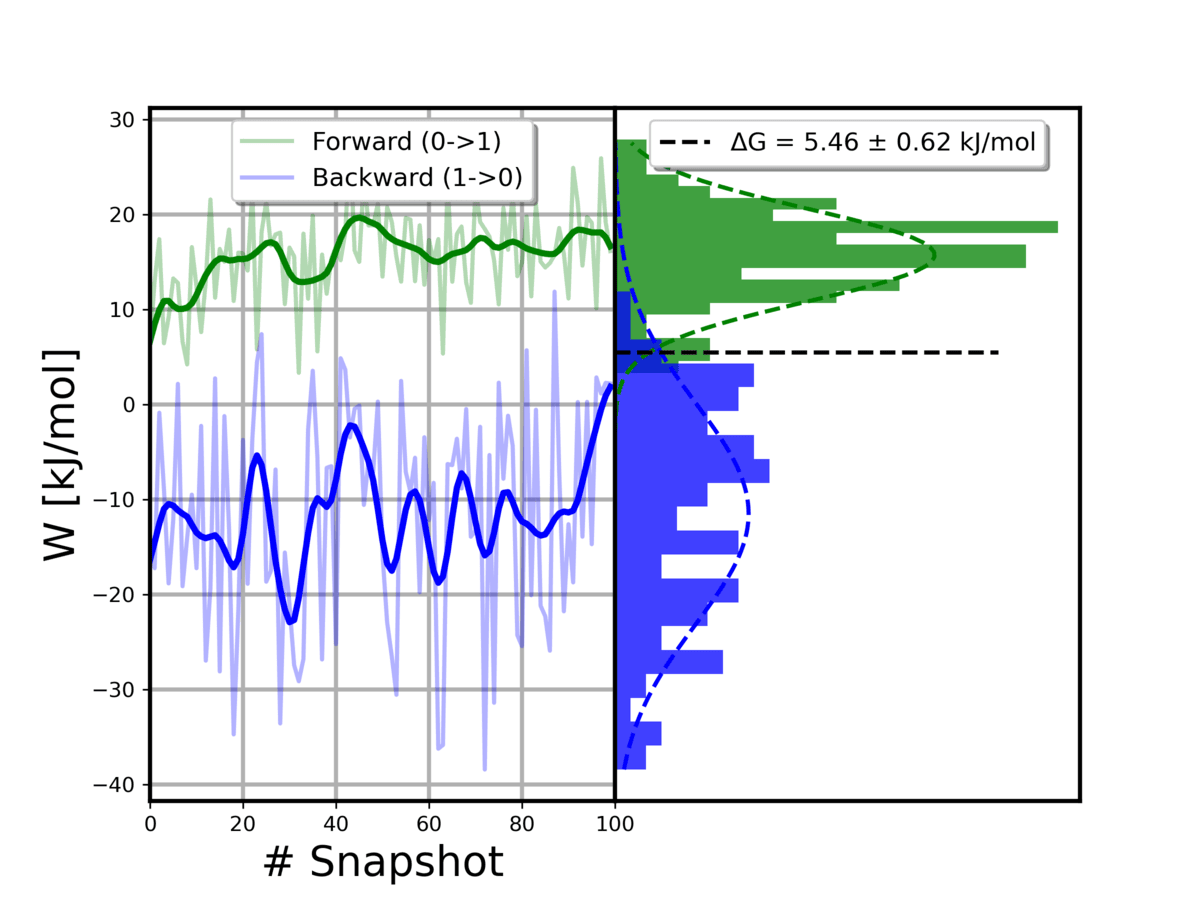

`4b.` Often, the easiest way to get reliable error estimates is to just repeat the whole calculation multiple times to obtain a standard error.<br>
For this example, we repeated the above steps 5 times (`fe.replicas = 5`), and obtained the following mean and standard error: <br>
                $~~~~~~~~~~~~~~~~~~~~  \Delta G^{Mutation}_{Folded}=4.08 \pm 0.93 ~kJ/mol$

----------------
Step 5. Final results
------------------

At this point, if you still remember, the number we were interested in was $\Delta \Delta G^{Mutation}_{Folding}$, that is, the change in the folding free energy upon introducing the W6F mutation. <br>
This value is recovered from $\Delta G^{Mutation}_{Folded}$, which we just calculated, and $\Delta G^{Mutation}_{Unfolded}$, which you can obtain by running the calculations starting from inputs/tripeptide.pdb rather than inputs/protein.pdb. <br> 
Using 5 repeats, we obtained the following mean and standard error for the latter free energy difference:
$\Delta G^{Mutation}_{Unfolded} = -11.518\pm0.19 ~kJ/mol$ <br>
Thus, our final result of interest is the following: <br>
$\Delta \Delta G^{Mutation}_{Folding} = \Delta G^{Mutation}_{Folded} − \Delta \Delta G^{Mutation}_{Unfolded} = 4.08\pm0.93 - (-11.518\pm0.19) = 15.60\pm0.95 ~kJ/mol$

**This suggests that the W6F mutation has a destabilising effect on the fold of Trp-cage of about $15.60\pm0.95 ~kJ/mol$, which is not far from the experimentally determined value of $12.5\pm0.6 ~kJ/mol$.**

------------------
# Further
------------------

- If you want to dig deeper and get an idea of all the interesting things happening behind, please have a look at **AAtutorial.py**.
- If time permits one could increase the transition time from 50 ps to 100/200 ps and see how the $\Delta G$ estimate changes. One should not expect too a large variation as long as the two work distributions overlap.
- Check out our other tutorials on solvation free energy, protein-ligand RBFE, etc.
- **Got any question related to PMX? Ask at https://ask.bioexcel.eu/.**